### Image Colorization with OpenVINO

This notebook demonstrates how to colorize images with OpenVINO using the Colorization model [colorization-v2](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/colorization-v2/README.md) or [colorization-siggraph](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/public/colorization-siggraph) from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/index.md) based on the paper [Colorful Image Colorization](https://arxiv.org/abs/1603.08511) models from Open Model Zoo.

![Let there be color](https://user-images.githubusercontent.com/18904157/180923280-9caefaf1-742b-4d2f-8943-5d4a6126e2fc.png)


Given a grayscale image as input, the model generates colorized version of the image as the output.

#### About Colorization-v2
* The colorization-v2 model is one of the colorization group of models designed to perform image colorization.
* Model trained on the ImageNet dataset.
* Model consumes L-channel of LAB-image as input and produces predict A- and B-channels of LAB-image as output.

#### About Colorization-siggraph
* The colorization-siggraph model is one of the colorization group of models designed to real-time user-guided image colorization.
* Model trained on the ImageNet dataset with synthetically generated user interaction.
* Model consumes L-channel of LAB-image as input and produces predict A- and B-channels of LAB-image as output.

See the [colorization](https://github.com/richzhang/colorization) repository for more details.

## Imports

In [1]:
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from openvino.runtime import Core

sys.path.append("../utils")
import notebook_utils as utils

## Configurations

* `PRECISION` - {FP16, FP32}, default: FP16.
* `MODEL_DIR` - directory where the model is to be stored, default: public.
* `MODEL_NAME` - name of the model used for inference, default: colorization-v2.
* `DATA_DIR` - directory where test images are stored, default: data.
* `DEVICE` - {CPU, GPU} device to used for inference, default: CPU.

In [2]:
PRECISION = "FP16"
MODEL_DIR = "models"
MODEL_NAME = "colorization-v2"
# MODEL_NAME="colorization-siggraph"
MODEL_PATH = f"{MODEL_DIR}/public/{MODEL_NAME}/{PRECISION}/{MODEL_NAME}.xml"
DATA_DIR = "data"
DEVICE = "CPU"

## Download the model

`omz_downloader` downloads model files from online sources and, if necessary, patches them to make them more usable with Model Converter.

In this case, `omz_downloader` downloads the checkpoint and pytorch model of [colorization-v2](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/colorization-v2/README.md) or [colorization-siggraph](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/public/colorization-siggraph) from [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/blob/master/models/public/index.md) and saves it under `MODEL_DIR`, as specified in the configuration above.

In [3]:
download_command = (
    f"omz_downloader "
    f"--name {MODEL_NAME} "
    f"--output_dir {MODEL_DIR} "
    f"--cache_dir {MODEL_DIR}"
)
! $download_command

################|| Downloading colorization-v2 ||################

========== Downloading models\public\colorization-v2\ckpt\colorization-v2-eccv16.pth
... 0%, 1024 KB, 1192 KB/s, 0 seconds passed
... 1%, 2048 KB, 1899 KB/s, 1 seconds passed
... 2%, 3072 KB, 2553 KB/s, 1 seconds passed
... 3%, 4096 KB, 3197 KB/s, 1 seconds passed
... 4%, 5120 KB, 3812 KB/s, 1 seconds passed
... 4%, 6144 KB, 4369 KB/s, 1 seconds passed
... 5%, 7168 KB, 4933 KB/s, 1 seconds passed
... 6%, 8192 KB, 5350 KB/s, 1 seconds passed
... 7%, 9216 KB, 5727 KB/s, 1 seconds passed
... 8%, 10240 KB, 6128 KB/s, 1 seconds passed
... 8%, 11264 KB, 6436 KB/s, 1 seconds passed
... 9%, 12288 KB, 6722 KB/s, 1 seconds passed
... 10%, 13312 KB, 6984 KB/s, 1 seconds passed
... 11%, 14336 KB, 7225 KB/s, 1 seconds passed
... 12%, 15360 KB, 7391 KB/s, 2 seconds passed
... 13%, 16384 KB, 7599 KB/s, 2 seconds passed
... 13%, 17408 KB, 7792 KB/s, 2 seconds passed
... 14%, 18432 KB, 7972 KB/s, 2 seconds passed
... 15%, 19456 KB, 8140

## Convert the model to OpenVINO IR

`omz_converter` converts the models that are not in the OpenVINO™ IR format into that format using Model Optimizer.

The downloaded pytorch model is not in OpenVINO IR format which is required for inference with OpenVINO runtime. `omz_converter` is used to convert the downloaded pytorch model into ONNX and OpenVINO IR format respectively

In [4]:
if not os.path.exists(MODEL_PATH):
    convert_command = (
        f"omz_converter "
        f"--name {MODEL_NAME} "
        f"--download_dir {MODEL_DIR} "
        f"--precisions {PRECISION}"
    )
    ! $convert_command

========== Converting colorization-v2 to ONNX
Conversion to ONNX command: C:\Users\adnan\OneDrive\Desktop\intelcc\openvino_env\Scripts\python.exe -- C:\Users\adnan\OneDrive\Desktop\intelcc\openvino_env\lib\site-packages\openvino\model_zoo\internal_scripts\pytorch_to_onnx.py --model-path=models\public\colorization-v2 --model-name=ECCVGenerator --weights=models\public\colorization-v2/ckpt/colorization-v2-eccv16.pth --import-module=model --input-shape=1,1,256,256 --output-file=models\public\colorization-v2/colorization-v2-eccv16.onnx --input-names=data_l --output-names=color_ab

ONNX check passed successfully.

========== Converting colorization-v2 to IR (FP16)
Conversion command: C:\Users\adnan\OneDrive\Desktop\intelcc\openvino_env\Scripts\python.exe -- C:\Users\adnan\OneDrive\Desktop\intelcc\openvino_env\Scripts\mo.exe --framework=onnx --output_dir=C:\Users\adnan\AppData\Local\Temp\tmp6z9_5ufq --model_name=colorization-v2 --input=data_l --output=color_ab --input_model=models\public\colo

## Loading the Model
Load the model in OpenVINO Runtime with `ie.read_model` and compile it for the specified device with `ie.compile_model`.

In [5]:
ie = Core()
model = ie.read_model(model=MODEL_PATH)
compiled_model = ie.compile_model(model=model, device_name=DEVICE)
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)
N, C, H, W = list(input_layer.shape)

## Utility Functions

In [6]:
def read_image(impath: str) -> np.ndarray:
    """
    Returns an image as ndarra, given path to an image reads the
    (BGR) image using opencv's imread() API.

        Parameter:
            impath (string): Path of the image to be read and returned.

        Returns:
            image (ndarray): Numpy array representing the read image.
    """

    raw_image = cv2.imread(impath)
    if raw_image.shape[2] > 1:
        image = cv2.cvtColor(
            cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2RGB
        )
    else:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

    return image


def plot_image(image: np.ndarray, title: str = "") -> None:
    """
    Given a image as ndarray and title as string, display it using
    matplotlib.

        Parameters:
            image (ndarray): Numpy array representing the image to be
                             displayed.
            title (string): String representing the title of the plot.

        Returns:
            None

    """

    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()


def plot_output(gray_img: np.ndarray, color_img: np.ndarray) -> None:
    """
    Plots the original (bw or grayscale) image and colorized image
    on different column axes for comparing side by side.

        Parameters:
            gray_image (ndarray): Numpy array representing the original image.
            color_image (ndarray): Numpy array representing the model output.

        Returns:
            None
    """

    fig = plt.figure(figsize=(12, 12))

    ax1 = fig.add_subplot(1, 2, 1)
    plt.title("Input", fontsize=20)
    ax1.axis("off")

    ax2 = fig.add_subplot(1, 2, 2)
    plt.title("Colorized", fontsize=20)
    ax2.axis("off")

    ax1.imshow(gray_img)
    ax2.imshow(color_img)

    plt.show()

## Load the Image 

In [12]:
img_url_0 = "https://images.pexels.com/photos/57905/pexels-photo-57905.jpeg?cs=srgb&dl=pexels-jack-hawley-57905.jpg&fm=jpg"
img_url_1 = "https://user-images.githubusercontent.com/18904157/180923289-0bb71e09-25e1-46a6-aaf1-e8f666b62d26.jpg"

image_file_0 = utils.download_file(
    img_url_0, filename="test_0.jpg", directory="data", show_progress=False, silent=True, timeout=30
)
assert Path(image_file_0).exists()

image_file_1 = utils.download_file(
    img_url_1, filename="test_1.jpg", directory="data", show_progress=False, silent=True, timeout=30
)
assert Path(image_file_1).exists()

test_img_0 = read_image("data/test_0.jpg")
test_img_1 = read_image("data/test_1.jpg")

In [13]:
def colorize(gray_img: np.ndarray) -> np.ndarray:

    """
    Given an image as ndarray for inference convert the image into LAB image, 
    the model consumes as input L-Channel of LAB image and provides output 
    A & B - Channels of LAB image. i.e returns a colorized image

        Parameters:
            gray_img (ndarray): Numpy array representing the original
                                image.

        Returns:
            colorize_image (ndarray): Numpy arrray depicting the
                                      colorized version of the original
                                      image.
    """
    
    # Preprocess
    h_in, w_in, _ = gray_img.shape
    img_rgb = gray_img.astype(np.float32) / 255
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab)
    img_l_rs = cv2.resize(img_lab.copy(), (W, H))[:, :, 0]

    # Inference
    inputs = np.expand_dims(img_l_rs, axis=[0, 1])
    res = compiled_model([inputs])[output_layer]
    update_res = np.squeeze(res)

    # Post-process
    out = update_res.transpose((1, 2, 0))
    out = cv2.resize(out, (w_in, h_in))
    img_lab_out = np.concatenate((img_lab[:, :, 0][:, :, np.newaxis],
                                  out), axis=2)
    img_bgr_out = np.clip(cv2.cvtColor(img_lab_out, cv2.COLOR_Lab2RGB), 0, 1)
    colorized_image = (cv2.resize(img_bgr_out, (w_in, h_in))
                       * 255).astype(np.uint8)
    return colorized_image

In [14]:
color_img_0 = colorize(test_img_0)
color_img_1 = colorize(test_img_1)

## Display Colorized Image

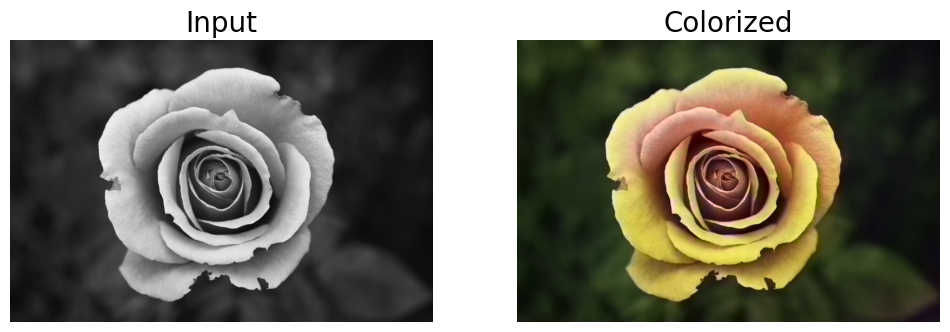

In [15]:
plot_output(test_img_0, color_img_0)

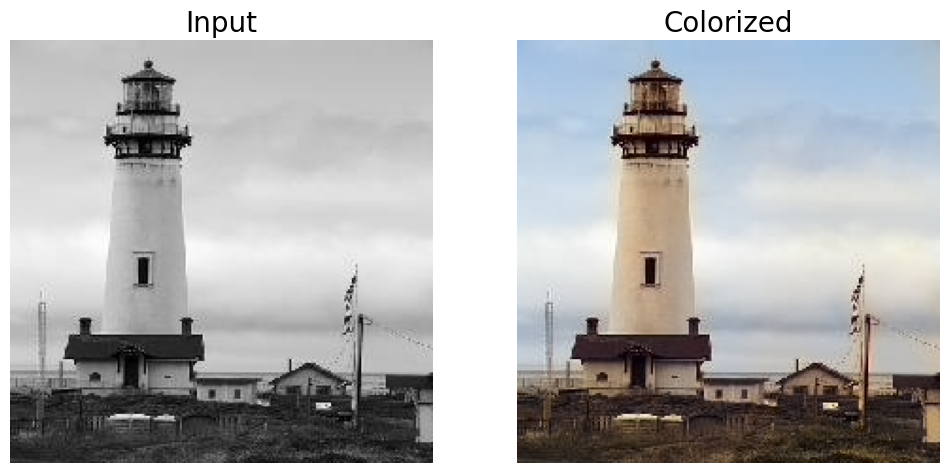

In [11]:
plot_output(test_img_1, color_img_1)